In [2]:
from glob import glob
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image, ImageDraw
import os
from data import basic_entities as entities
import pickle
from math import floor

# Format (point1, point2, ped_size(head-torso) (x,y)
lines = {
    'IM01': [
        # Bottom
        ((150, 700), (750, 450), (35, 75)),
        # Top
        ((60, 220), (500, 50), (55, 50))
    ],
    'IM02': [
        # Bottom left
        ((320, 400), (500, 450), (45,55)),
        # Bottom right
        ((550, 400), (900, 470), (35,55)),
        # Middle
        ((400, 200), (850, 260), (30,45)),
        # Top
        ((450, 50), (900, 100), (20,40))
    ],
    'IM03': [
        # Middle all
        ((600, 550), (640, 250), (20, 20)),
        # Single line, top
        ((800, 380), (810, 300), (20, 20)),
        # Small line, right
        ((1000, 390), (980, 600), (20, 25))
    ],
    'IM04': [
        # Top centre
        ((740, 160), (830, 90), (30,20)),
        # Left centre
        ((750, 350), (920, 480), (30,30)),
        # Top
        ((200, 200), (520, 0), (30, 30)),
        # Left
        ((20, 250), (300, 720), (25,25))
    ],
    'IM05': [
        # Bottom
        ((600, 400), (610, 719), (35,45)),
        # Right
        #((800, 300), (1200, 250), (20,35)),
        # Left
        ((0, 250), (350, 380), (45,40))
    ]
}

# Load all the videos of the TUB dataset and load the positions of the pedestrians
# @todo Load the tracking of the different pedestrians. (Not required for training right now)
def load_all_videos(path, load_peds=True):
    # Load all the videos from the path and load it into vidoe/frame objects
    videos = []
    for image_dir in glob('{}/images/IM??'.format(path)):
        base = os.path.basename(image_dir)
        frame_files = glob('{}/*.png'.format(image_dir))
        frame_files.sort()

        video = entities.BasicVideo(image_dir)
        videos.append(video)
        for file_path in frame_files:
            frame_obj = entities.BasicFrame(file_path)
            video.add_frame(frame_obj)

        if base not in lines:
            print("Skipped {}".format(base))
            continue

        frames = video.get_frames()

        # Open pedestrians information
        if load_peds:
            track_path = '{}/PersonTracks.pb'.format(image_dir.replace('images', 'gt_trajectories'))
            ret = pickle.load(open(track_path, 'rb'))

            # Loop per pedestrian over the frames
            for i, pedestrian in enumerate(ret['GT_Trajectories']):
                arr = np.array(pedestrian)
                arr = arr[:, [1, 0]]

                for o, loc in enumerate(arr):

                    if o + 5 < len(arr):
                        speed = np.linalg.norm(np.array(arr[o]) - np.array(arr[o + 5]))
                        if speed > 3:
                            moving = True
                        else:
                            moving = False
                    else:
                        moving = False

                    frame_id = int(ret['GT_StartPoints'][i][0] + o)
                    frames[frame_id].add_point((loc[0], loc[1]), moving=moving)
                    # TODO: Add tracking, now we haven't connected the track between frames.


            # Load crosses into lines
            crosses = get_line_crossing_frames(video)
            video_lines = lines[os.path.basename(video.get_path())]
            for o, line in enumerate(video_lines):
                line_obj = entities.BasicLineSample(video, line[0], line[1])
                video.add_line(line_obj)

                for cross in crosses[o][0]:
                    line_obj.add_crossing(cross, 0)

                for cross in crosses[o][1]:
                    line_obj.add_crossing(cross, 1)
        
        #Skip beat, because it's weird
        video.frames = video.frames[1:]

    return videos

# Load all the frames from the video
def load_all_frames(base_path, load_labeling=True):
    frames = []
    for video_path in load_all_videos(base_path, load_peds=load_labeling):
        frames = frames + video_path.get_frames()

    return frames

# Get per video when a pedestrian crosses a line (Get all the information of all the lines of the video)
def get_line_crossing_frames(video):
    # So this function returns a tupple with each an array which gives the frame number that a person crossed a line.
    # This makes it pretty easy to split the long videos into smaller samples
    base = os.path.basename(video.get_path())

    track_path = '{}/PersonTracks.pb'.format(video.get_path().replace('images', 'gt_trajectories'))
    ret = pickle.load(open(track_path, 'rb'))

    video_crosses = {}
    for o, line in enumerate(lines[base]):

        crosses = [[], []]
        for i, pedestrian in enumerate(ret['GT_Trajectories']):

            arr = np.array(pedestrian)
            arr = arr[:, [1, 0]]

            base_point = np.array(line[0])
            vector = np.array(line[1])
            norm_vector = vector - base_point
            norm_arr = arr - base_point

            # Project to check which points fall inside the line
            upper_proj = np.dot(norm_arr, norm_vector)
            lower_proj = np.linalg.norm(norm_vector) ** 2
            proj = upper_proj / lower_proj
            inside = np.array([proj >= 0, proj <= 1]).all(axis=0)

            # Are you on the right side of the line
            check = (norm_vector[0] * norm_arr[:, 1] - norm_vector[1] * norm_arr[:, 0]) > 0;

            # If it didn't cross, then no need to check further
            if np.all(check == check[0]):
                continue

            check2 = np.roll(check, 1)
            together = check[1:] != check2[1:]
            poses = np.where(together == True)[0]

            pos = None
            for pos_i in poses:
                if inside[pos_i] == False:
                    continue

                # Some weird start displacements are filtered out this way
                norm = np.linalg.norm([arr[pos_i, 0] - arr[pos_i + 1, 0], arr[pos_i, 1] - arr[pos_i + 1, 1]])
                if norm > 20:
                    continue

                pos = pos_i

            if pos == None:
                continue

            crossing_frame = int(ret['GT_StartPoints'][i][0] + pos + 2)
            if crossing_frame < 1: # Skip first frame
                continue
                
            crosses[int(check[pos + 1])].append(crossing_frame)

        video_crosses[o] = crosses

    return video_crosses

# Split the video and the crossing information into train and test information
def split_train_test(videos, train=0.5):
    train_videos = []
    test_videos = []
    for video in videos:
        frames = video.get_frames()
        train_vid = entities.BasicVideo(video.get_path())
        test_vid = entities.BasicVideo(video.get_path())

        test_start_index = int(len(frames)*train)

        # Copy line information and split
        for line in video.get_lines():
            train_line = entities.BasicLineSample(train_vid, line.get_line()[0], line.get_line()[1])
            train_vid.add_line(train_line)
            test_line = entities.BasicLineSample(test_vid, line.get_line()[0], line.get_line()[1])
            test_vid.add_line(test_line)

            for cross in line.get_crossings(0):
                if cross < test_start_index:
                    train_line.add_crossing(cross, 0)
                else:
                    test_line.add_crossing(cross-test_start_index, 0)

            for cross in line.get_crossings(1):
                if cross < test_start_index:
                    train_line.add_crossing(cross, 1)
                else:
                    test_line.add_crossing(cross-test_start_index, 1)

        # Split frames
        for frame in frames[:test_start_index]:
            train_vid.add_frame(frame)

        for frame in frames[test_start_index:]:
            test_vid.add_frame(frame)

        train_videos.append(train_vid)
        test_videos.append(test_vid)

    return train_videos, test_videos

def train_val_test_split(videos, test_size=0.5, train_size=0.1):
    train_videos, rest = split_train_test(videos, train=train_size)
    left_perc = (1.0-train_size-test_size)/(1.0-train_size)
    val_videos, test_videos = split_train_test(videos, train=left_perc)

    return train_videos, val_videos, test_videos

# Split a video (So probably only a test/validation video) into multiple shorter samples.
# Sample_overlap is the amount of frames the begin of sample 1 and begin of sample 2 are apart.
def get_samples_from_video(video, crossing_frames, sample_length=50, sample_overlap=50):
    # Split the long video into shorter samples and per line
    base = os.path.basename(video.get_path())
    frames = video.get_frames()
    count_frames = len(frames)

    if base not in lines:
        print('{} has not lines'.format(base))
        return

    video_samples = []
    for line_i in crossing_frames:
        line_crosses = crossing_frames[line_i]

        # Extract from the validation part, take smaller parts as evaluation sample
        for o in range(0, count_frames - sample_overlap + 1, sample_overlap):
            start_sample = o
            end_sample = min(o + sample_length, count_frames)
            # Check all the original frame jumps and take only the ones with this sample
            check_line_crosses = []
            for line_cross in line_crosses:
                valid_line_cross = []
                for frame_jump in line_cross:
                    if frame_jump >= start_sample and frame_jump < end_sample:
                        valid_line_cross.append(frame_jump)
                check_line_crosses.append(valid_line_cross)

            # Make the sample into a video
            sample_video = entities.BasicVideo(video.get_path())
            val_frames = frames[start_sample:end_sample]
            for frame in val_frames:
                sample_video.add_frame(frame)

            video_samples.append([sample_video, lines[base][int(line_i)], check_line_crosses, (base, line_i)])

    return video_samples

In [7]:
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt
import numpy as np
def gaussian_filter_fixed_density(frame, sigma=16):
    img = plt.imread(frame.get_image_path())
    img_shape = [img.shape[0], img.shape[1]]

    density = np.zeros(img_shape, dtype=np.float32)
    for dot in frame.get_centers():
        if dot[1] >= img.shape[0] or dot[1] < 0 or dot[0] >= img.shape[1] or dot[0] < 0:
            continue
        density[dot[1], dot[0]] = 1

    density = gaussian_filter(density, sigma, mode='constant')
    return density


In [53]:
import IPython.display
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
def show_img_dense(frame):
    density = gaussian_filter_fixed_density(frame, sigma=4)
    %matplotlib inline
    
    cc_img = Image.fromarray(density * 255.0 / density.max())
    cc_img = cc_img.convert("L")
    cc_img = cc_img.convert('RGB')
    
    blended = Image.blend(frame.get_image(), cc_img, alpha=0.6)
    display(blended)
    
#     fig= plt.figure(figsize=(18,10))
#     plt.imshow(density, interpolation='nearest')
#     plt.show()
    
#     display(frame.get_image())

-----


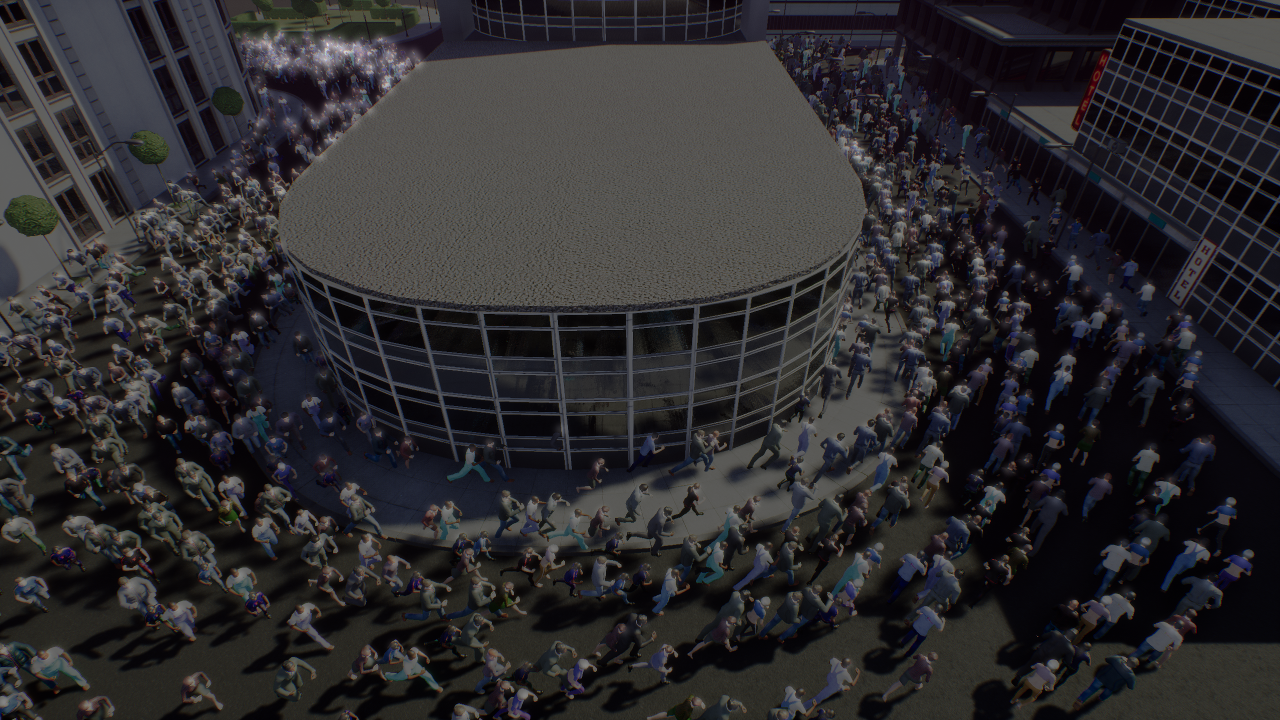

-----


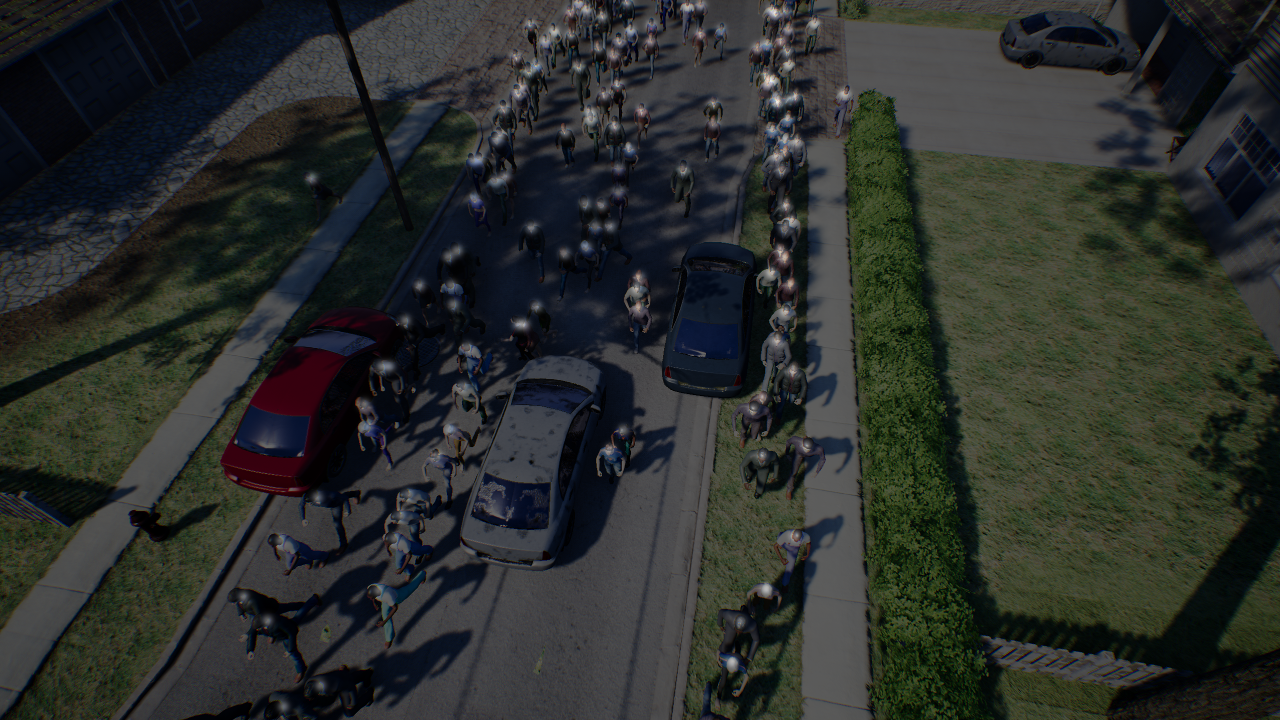

-----


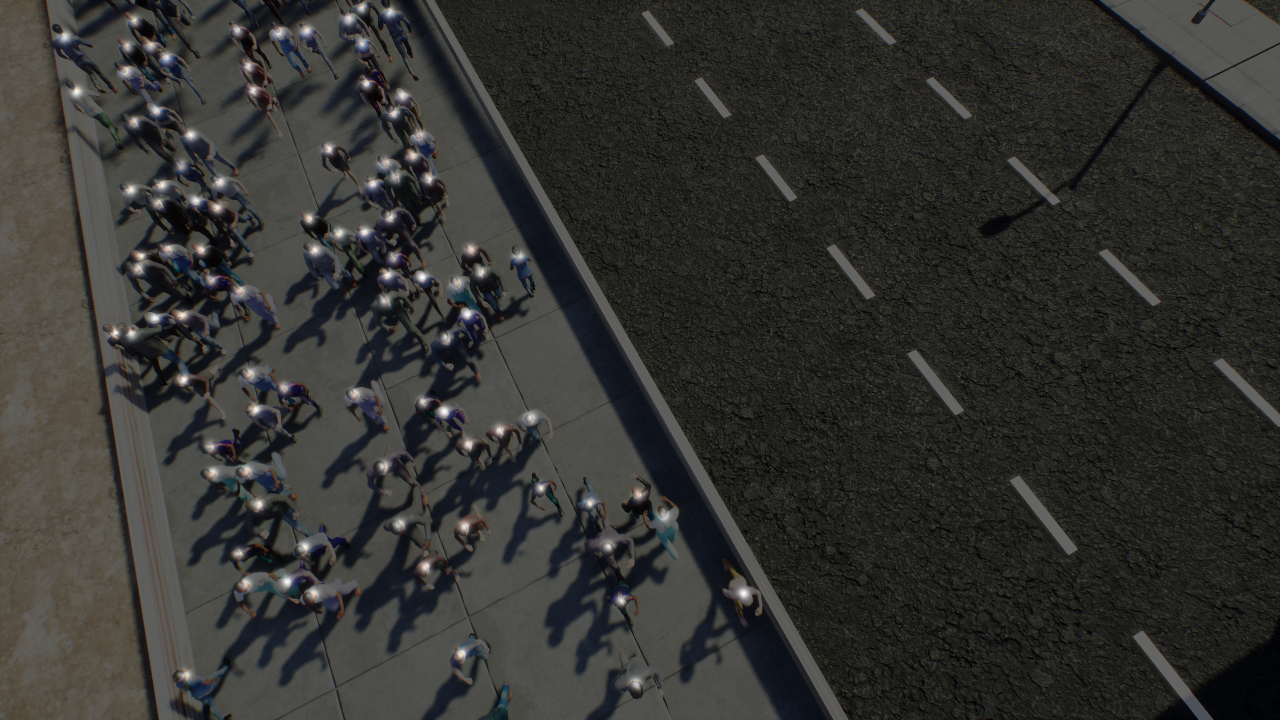

-----


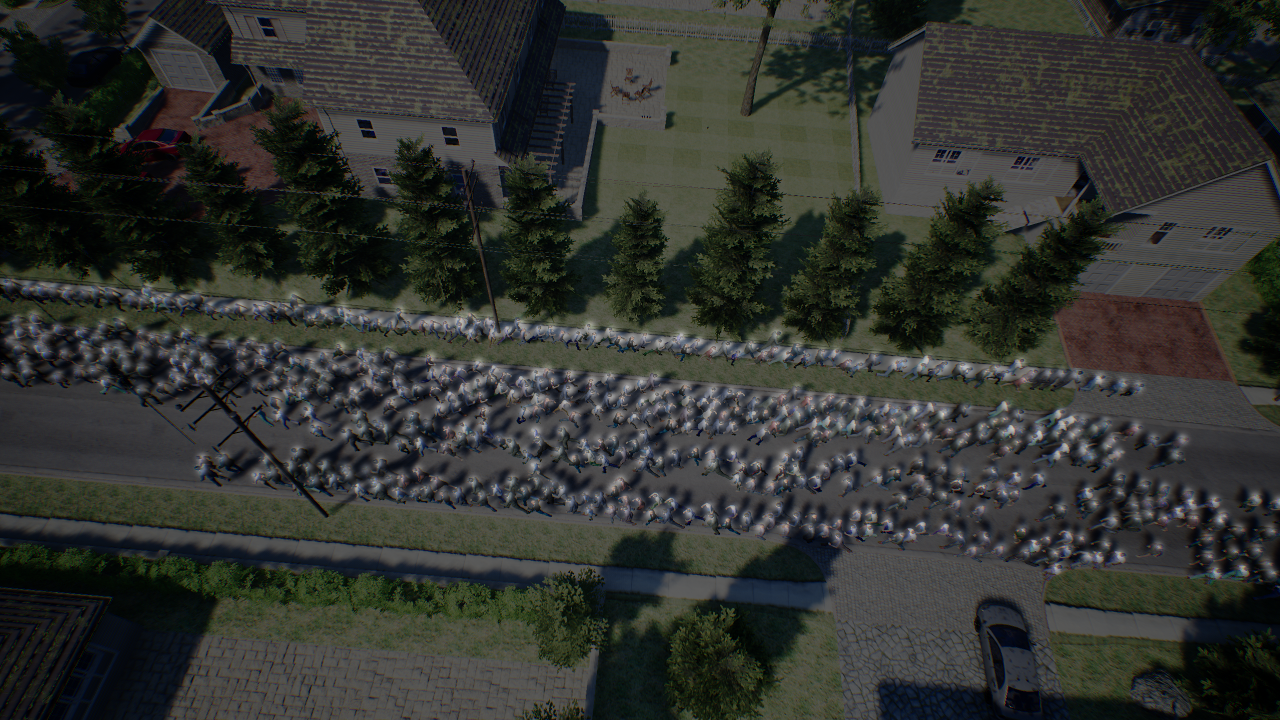

In [54]:
for video_path in load_all_videos('data/TUBCrowdFlow', load_peds=True):
    print("-----")
    show_img_dense(video_path.get_frames()[50])